In [12]:
import pip
pip.main(['install', 'scikit-image'])

  Using cached scikit_image-0.12.3-cp35-cp35m-manylinux1_x86_64.whl
  Using cached six-1.10.0-py2.py3-none-any.whl
  Using cached networkx-1.11-py2.py3-none-any.whl
  Using cached Pillow-3.3.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached dask-0.10.2-py2.py3-none-any.whl
  Using cached decorator-4.0.10-py2.py3-none-any.whl
  Using cached numpy-1.11.1-cp35-cp35m-manylinux1_x86_64.whl


You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

IMAGES_DIR = "/mnt/spin6TB/dirkgr/images"
IMAGES_DIR = "/Users/marvin/Downloads/images"
IMAGES_DIR = "/data/images"
MAX_IMAGE_SIZE = (500, 500)
FACTOR = 4
INPUT_SIZE = (MAX_IMAGE_SIZE[0] / FACTOR, MAX_IMAGE_SIZE[1] / FACTOR)

BATCH_SIZE = 16

In [5]:
import os
def allImageFilenames(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.endswith(".jpg"):
                yield os.path.join(root, f)

import skimage.io
def allRawImages(filenames):
    for filename in filenames:
        try:
            image = skimage.io.imread(filename)
            if image.shape[0] > MAX_IMAGE_SIZE[0]:
                raise ValueError("Image %s too big: %r" % (filename, image.shape))
            if image.shape[1] > MAX_IMAGE_SIZE[1]:
                raise ValueError("Image %s too big: %r" % (filename, image.shape))
            yield image
        except ValueError:
            print("Could not load image %s; skipping" % filename)
        
import skimage.util
def padImage(image):
    widthFactor = MAX_IMAGE_SIZE[0] - image.shape[0]
    heightFactor = MAX_IMAGE_SIZE[1] - image.shape[1]
    padValues = (
        tuple(map(int, (widthFactor / 2, widthFactor / 2 + widthFactor % 2))),
        tuple(map(int, (heightFactor / 2, heightFactor / 2 + heightFactor % 2))),
        (0, 0)
    )
    result = skimage.util.pad(image, padValues, 'constant', constant_values=0)
    return result

import skimage.transform
def scaleDown(image):
    return skimage.transform.rescale(image, 1.0/FACTOR)

def floatImage(image):
    return skimage.util.img_as_float(image)

import numpy
def axisFormatToKeras(image):
    return numpy.moveaxis(image, 2, 0)
def axisFormatFromKeras(image):
    return numpy.moveaxis(image, 0, 2)

import skimage.color
def colorsToCIE(image):
    return skimage.color.convert_colorspace(image, 'RGB', 'RGB CIE')
def colorsFromCIE(image):
    return skimage.color.convert_colorspace(image, 'RGB CIE', 'RGB')

filenames = list(allImageFilenames(IMAGES_DIR))
TRAIN_VALIDATE_TEST_FRACTIONS = (0.7, 0.2, 0.1)
cutoffs = (
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0]),
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0] + TRAIN_VALIDATE_TEST_FRACTIONS[1])
)
filenames_train = filenames[:cutoffs[0]]
filenames_validate = filenames[cutoffs[0]:cutoffs[1]]
filenames_test = filenames[cutoffs[1]:]

def makeData(filenames):
    for rawImage in allRawImages(filenames):
        padded = floatImage(padImage(rawImage))
        yield map(axisFormatToKeras, map(colorsToCIE, (scaleDown(padded), padded)))
        
def loopInfinitely(generatorGenerator):
    while True:
        for item in generatorGenerator():
            yield item
            
def makeInfiniteDataBatches(filenames):
    def makeGeneratorFromBeginning():
        return makeData(filenames)
    generator = loopInfinitely(makeGeneratorFromBeginning)
    accumulator = []
    for item in generator:
        accumulator.append(item)
        if len(accumulator) >= BATCH_SIZE:
            # accumulator is now a list of (input, label) tuples
            accumulator = zip(*accumulator)
            # accumulator is now a list of length 2, like this: [(input1, input2, ...), (label1, label2, ...)]
            yield map(numpy.stack, accumulator)
            accumulator = []
        
train = makeInfiniteDataBatches(filenames_train)
validate = makeInfiniteDataBatches(filenames_validate)
test = makeInfiniteDataBatches(filenames_test)

print("Done")

Done


In [6]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, UpSampling2D

model = Sequential()
model.add(Convolution2D(16, 5, 5, activation="relu", border_mode='same', input_shape = (3,) + INPUT_SIZE))
model.add(UpSampling2D())
model.add(Convolution2D(16, 7, 7, activation="relu", border_mode='same'))
model.add(UpSampling2D())
model.add(Convolution2D(16, 7, 7, activation="relu", border_mode='same'))
model.add(Convolution2D(3, 7, 7, activation="relu", border_mode='same'))
model.add(Activation("tanh"))  # make sure all outputs are between 0 and 1
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 16, 125.0, 125.1216        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
upsampling2d_3 (UpSampling2D)    (None, 16, 250.0, 250.0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 16, 250.0, 250.12560       upsampling2d_3[0][0]             
____________________________________________________________________________________________________
upsampling2d_4 (UpSampling2D)    (None, 16, 500.0, 500.0           convolution2d_6[0][0]            
___________________________________________________________________________________________

.

Iteration 0
Train loss: 0.003535	Test loss: 0.002056


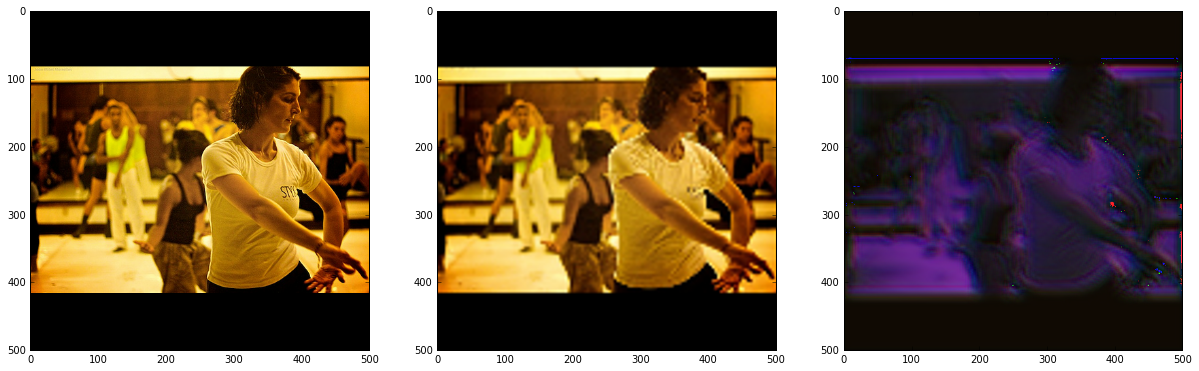

Original: 0.00000	Scikit: 0.00234	Net: 0.10185


................

Iteration 16
Train loss: 0.000457	Test loss: 0.000421


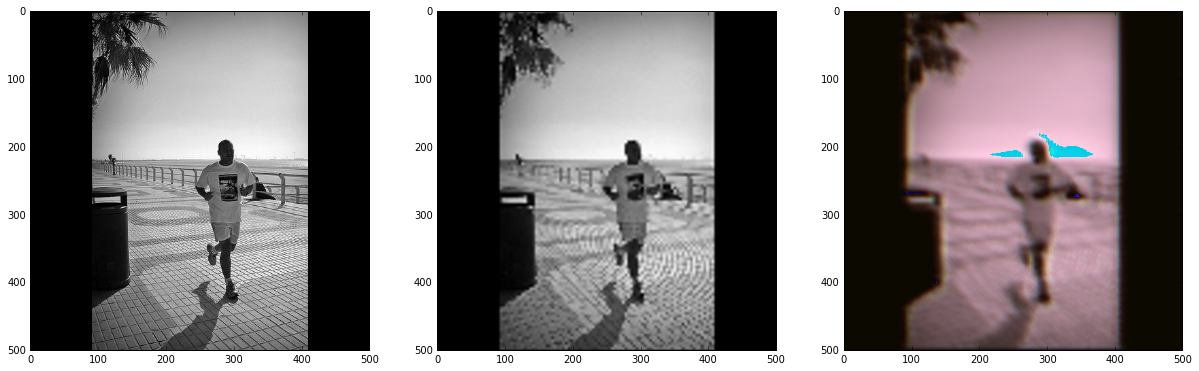

Original: 0.00000	Scikit: 0.00707	Net: 0.01363


......

In [ ]:
def mse(a, b):
    return ((a - b) ** 2).mean(axis = None)

for i in range(10240):
    x_train, y_train = next(train)
    (train_loss, train_acc) = model.train_on_batch(x_train, y_train)
    print('.', end="")

    if i % 16 == 0:
        print("\n")
        x_test, y_test = next(test)
        (test_loss, test_acc) = model.test_on_batch(x_test, y_test)

        print("Iteration %i\nTrain loss: %f\tTest loss: %f" % (i, train_loss, test_loss))

        prediction = model.predict_on_batch(x_test)

        firstOriginal = y_test[0]
        firstOriginal = colorsFromCIE(axisFormatFromKeras(firstOriginal))

        firstScaledDown = x_test[0]
        firstScaledDown = colorsFromCIE(axisFormatFromKeras(firstScaledDown))

        # try all interpolation methods that scikit has, and pick the best
        firstScaledByScikit = skimage.transform.rescale(firstScaledDown, FACTOR, order=3)
        
        firstScaledByNet = prediction[0]
        firstScaledByNet = colorsFromCIE(axisFormatFromKeras(firstScaledByNet))

        f, (originalFig, scikitFig, netFig) = plt.subplots(1, 3)
        f.set_figheight(700/92)
        f.set_figwidth(1900/92)
        originalFig.imshow(firstOriginal)
        scikitFig.imshow(firstScaledByScikit)
        netFig.imshow(firstScaledByNet)
        plt.show()
        
        print(
            "Original: %.5f\tScikit: %.5f\tNet: %.5f" % (
                mse(firstOriginal, firstOriginal),
                mse(firstOriginal, firstScaledByScikit),
                mse(firstOriginal, firstScaledByNet)))
        print("\n")

In [15]:
model.evaluate_generator(test, 256)

#plt.imshow(scaledImage)
#plt.imshow(paddedImage)

KeyboardInterrupt: 

In [20]:
(scaledDownBatch, originalBatch) = test.next() 
resultBatch = model.predict_on_batch(scaledDownBatch)

firstResult = resultBatch[0]
firstResult = axisFormatFromKeras(firstResult)

firstOriginal = originalBatch[0]
firstOriginal = axisFormatFromKeras(firstOriginal)

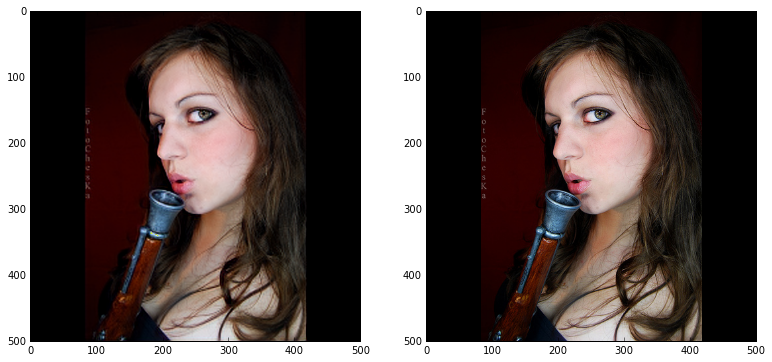

In [21]:
f, (resultFig, originalFig) = plt.subplots(1, 2)
f.set_figheight(600/92)
f.set_figwidth(1200/92)
resultFig.imshow(firstResult)
originalFig.imshow(firstOriginal)